Setup and Data Extraction

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/Eyes.zip

import tensorflow as tf
import matplotlib.pyplot as plt

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/Eyes.zip
   creating: Eyes/
   creating: Eyes/test/
   creating: Eyes/test/cataract/
 extracting: Eyes/test/cataract/cataract-100.jpg  
 extracting: Eyes/test/cataract/cataract-101.jpg  
  inflating: Eyes/test/cataract/cataract-103.jpg  
 extracting: Eyes/test/cataract/cataract-110.jpg  
  inflating: Eyes/test/cataract/cataract-117.jpg  
 extracting: Eyes/test/cataract/cataract-121.jpg  
  inflating: Eyes/test/cataract/cataract-122.jpg  
 extracting: Eyes/test/cataract/cataract-13.jpg  
 extracting: Eyes/test/cataract/cataract-135.jpg  
  inflating: Eyes/test/cataract/cataract-143.jpg  
 extracting: Eyes/test/cataract/cataract-168.jpg  
 extracting: Eyes/test/cataract/cataract-179.jpg  
  inflating: Eyes/test/cataract/cataract-190.jpg  
  inflating: Eyes/test/cataract/cataract-2.jpg  
 extracting: Eyes/test/cataract/cataract-201.jpg  
 extracting: Eyes/test/cataract/cataract-224.jpg  
 extracting: Eyes/test/cataract/cataract-

Data Preprocessing

In [7]:
img_height, img_width = 64, 64
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Visualization

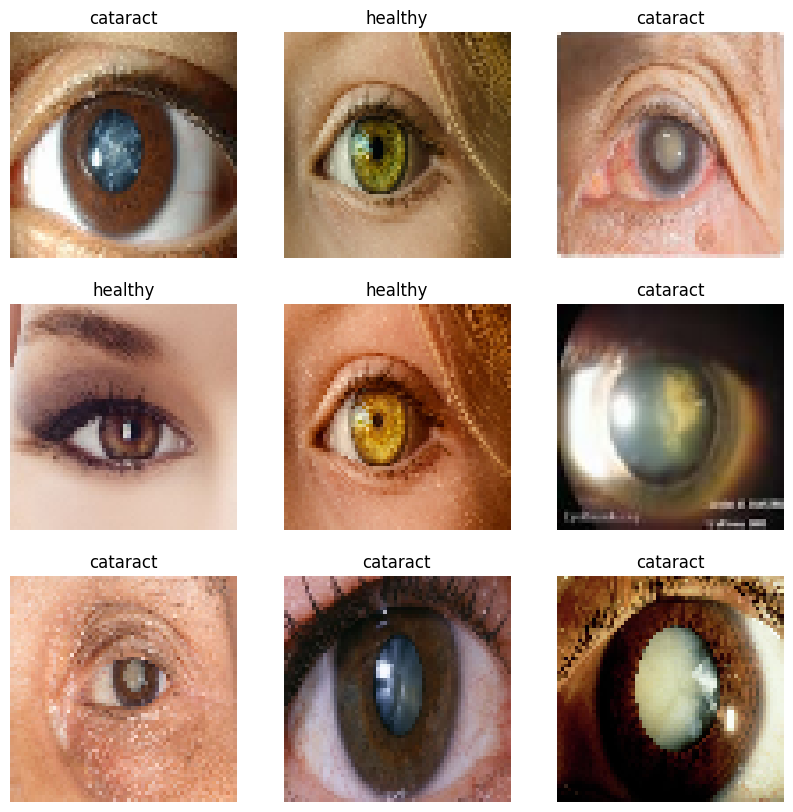

In [ ]:
class_names = ["cataract", "healthy"]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model Construction

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
    tf.keras.layers.Dense(2)
])

Compile the model

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

Model Training

In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 25
)

Epoch 1/25
25/25 [==============================] - 20s 536ms/step - loss: 0.6646 - accuracy: 0.6168 - val_loss: 0.6076 - val_accuracy: 0.5837
Epoch 2/25
25/25 [==============================] - 17s 530ms/step - loss: 0.5229 - accuracy: 0.7852 - val_loss: 0.4874 - val_accuracy: 0.8026
Epoch 3/25
25/25 [==============================] - 17s 530ms/step - loss: 0.4729 - accuracy: 0.8279 - val_loss: 0.4600 - val_accuracy: 0.7897
Epoch 4/25
25/25 [==============================] - 18s 484ms/step - loss: 0.4388 - accuracy: 0.8618 - val_loss: 0.3783 - val_accuracy: 0.9056
Epoch 5/25
25/25 [==============================] - 19s 623ms/step - loss: 0.4251 - accuracy: 0.8505 - val_loss: 0.3988 - val_accuracy: 0.8670
Epoch 6/25
25/25 [==============================] - 17s 538ms/step - loss: 0.4052 - accuracy: 0.8580 - val_loss: 0.3326 - val_accuracy: 0.9270
Epoch 7/25
25/25 [==============================] - 19s 554ms/step - loss: 0.3772 - accuracy: 0.8844 - val_loss: 0.3738 - val_accuracy: 0.8712

Plot Epoch VS Training and Validation Accuracy

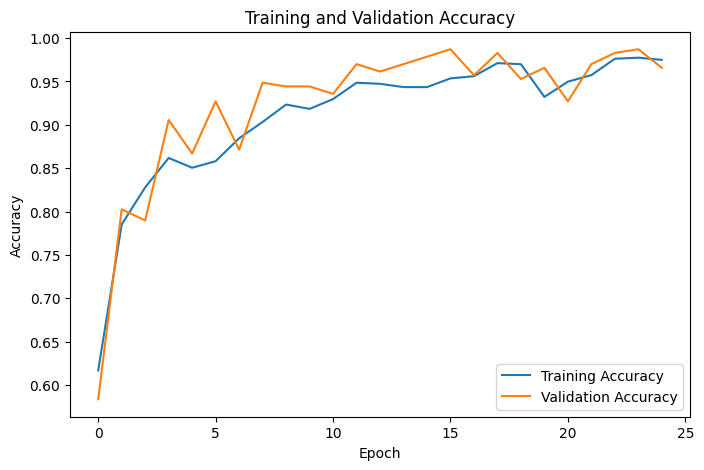

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(25)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Model Evaluation

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 27ms/step - loss: 0.1429 - accuracy: 0.9822


[0.14288540184497833, 0.9822221994400024]

Visualization of Predictions

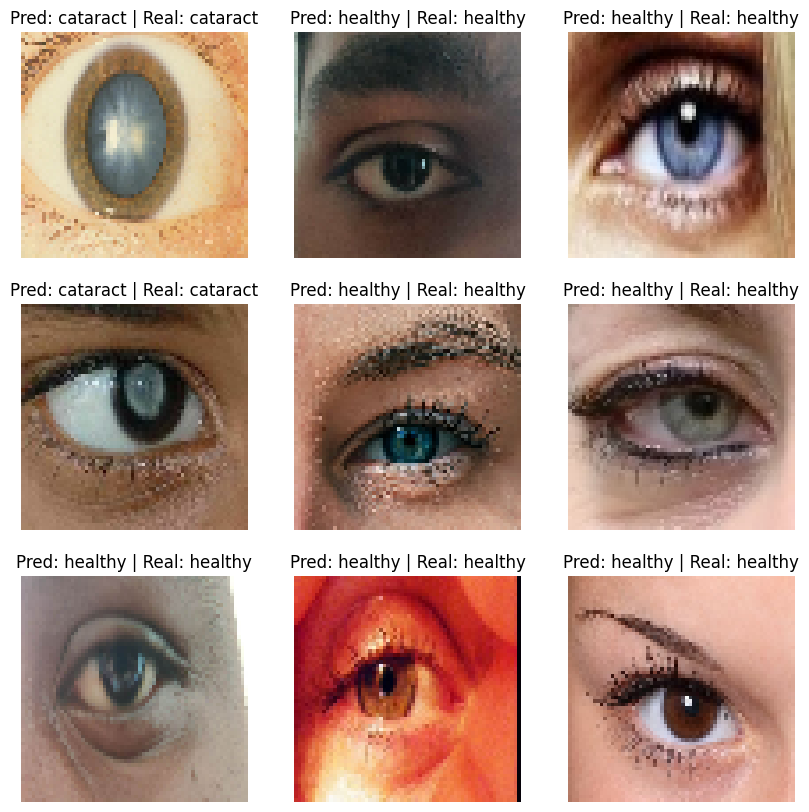

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = np.argmax(classifications[i])
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])
        plt.axis("off")

Convert and Save TensorFlow Model as TensorFlow Lite

In [ ]:
import os
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Evaluate the model to get its accuracy
accuracy = model.evaluate(test_ds)[1]  # Assuming the accuracy is the second value returned by evaluate

# Name the TensorFlow Lite file with accuracy
filename = f"model_accuracy_{accuracy:.4f}.tflite"  # Using 4 decimal places for accuracy
file_path = os.path.join("models", filename)  

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the TensorFlow Lite model to file
with open(file_path, 'wb') as f:
    f.write(tflite_model)

8/8 [==============================] - 5s 61ms/step - loss: 0.1429 - accuracy: 0.9822


Function to Measure Model Inference Execution Time

In [ ]:
import time
# Define a function to measure the execution time of a single run
def measure_execution_time(model, input_data):
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time

Run multiple iterations and measure the execution time for each iteration

In [ ]:
num_iterations = 5  # Adjust this as per your requirements
total_execution_time = 0

for _ in range(num_iterations):
    execution_time = measure_execution_time(model, test_ds)
    total_execution_time += execution_time

average_execution_time = total_execution_time / num_iterations

print("Average Execution Time:", average_execution_time)

8/8 [==============================] - 5s 43ms/step
Average Execution Time: 4.193167591094971


Plot precision, recall, and F1 score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict classes for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 0s 22ms/step
Precision: 0.9823705578403459
Recall: 0.9822222222222222
F1 Score: 0.9822187088274045


Plot Confusion matrix

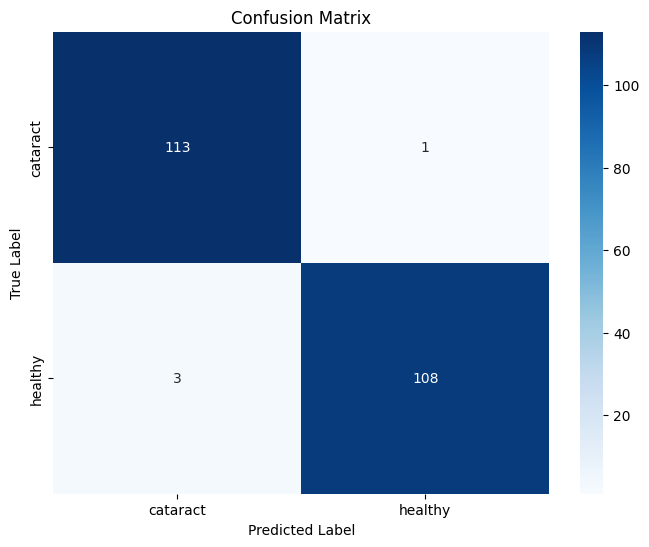

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Plot ROC CURVE

1/1 [==============================] - 0s 21ms/step


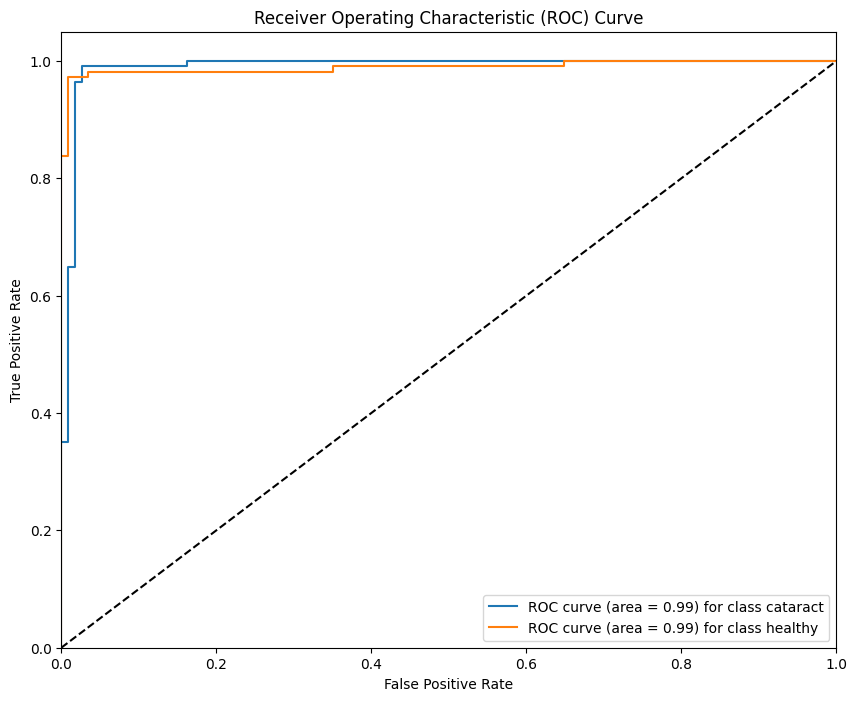

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels to one-hot encoding
y_true = to_categorical(y_true, num_classes=len(class_names))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()